In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

In [2]:
odf = pd.read_csv('Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

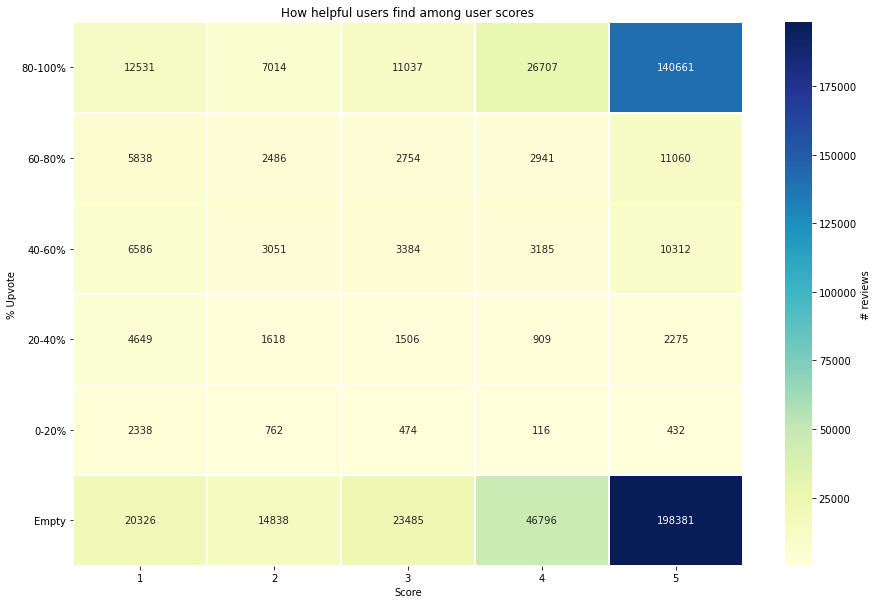

In [3]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

In [4]:
'''Reviews are skewed towards positive
More than half of the reviews are with zero votes
Many people agree with score 5 reviews'''
#Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

In [5]:
#Logistic regression model on word count
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


C:\Users\PREETHI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9357798165137615

-Top 20 positive-
        Word  Coefficient
  pleasantly     4.224796
    downside     3.120131
   addicting     2.953540
    drawback     2.665824
   skeptical     2.504228
      resist     2.376340
  economical     2.260940
        whim     2.231741
    soothing     2.215128
     easiest     2.204082
      hooked     2.168918
     welcome     2.080902
   delighted     2.074018
   excellent     1.976747
       meets     1.973538
         yay     1.972552
 wonderfully     1.967344
     worries     1.942192
 exceptional     1.938185
      delish     1.931104

-Top 20 negative-
          Word  Coefficient
         ruins    -2.302089
        lacked    -2.322946
         blech    -2.330041
    unfinished    -2.346251
    unbearable    -2.351975
           ick    -2.416646
    overpowers    -2.484597
   unappealing    -2.528266
   disapointed    -2.551836
       defeats    -2.610770
    returnable    -2.679978
      mediocre    -2.729830
        ripoff   

In [6]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.737018272551615


C:\Users\PREETHI\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [7]:
#Logistic regression model on TFIDF
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


C:\Users\PREETHI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9346995907313584

-Top 20 positive-
       Word  Coefficient
      great    13.823115
  delicious    12.292684
       best    11.929382
    perfect    10.690185
  excellent     9.998906
      loves     9.556067
     highly     8.930546
       love     8.323461
  wonderful     8.080655
    amazing     7.657185
 pleasantly     7.479284
    awesome     7.416257
       good     7.336907
       nice     7.092402
     hooked     7.084855
    pleased     6.922565
     smooth     6.867146
   favorite     6.849733
      yummy     6.752527
  fantastic     6.512756

-Top 20 negative-
           Word  Coefficient
          waste    -5.636691
           poor    -5.728368
    undrinkable    -5.889710
           yuck    -5.901257
          stale    -6.083224
          worse    -6.161696
          bland    -6.369801
           weak    -6.429666
     disgusting    -6.458630
      tasteless    -6.675855
          threw    -6.691069
         return    -6.791954
  unfortunately    -7.445

In [10]:
#Logistic regression model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


C:\Users\PREETHI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9454409907648302

-Top 20 positive-
             Word  Coefficient
            great    20.960132
             best    17.824644
        delicious    16.852510
          perfect    14.430293
            loves    13.613355
             love    13.267634
        excellent    12.937697
             good    11.381231
        wonderful    11.136372
             nice    10.803949
         favorite    10.609249
          amazing     9.504168
          awesome     9.205339
             easy     9.108804
            happy     8.879198
          pleased     8.709685
           smooth     8.557963
            yummy     8.459076
            tasty     8.395446
 highly recommend     8.377156

-Top 20 negative-
           Word  Coefficient
          maybe    -7.827054
         hoping    -7.983143
      tasteless    -8.144821
          worse    -8.218243
          money    -8.344444
        thought    -8.497877
     disgusting    -8.626682
          bland    -9.028154
          threw

In [11]:
#Upvote prediction
#This study is to see whether there is pattern found for unpopular (downvote) comments by users (might be used to boost sales). We will be focusing on score 5 reviews, and get rid of comments with neutral votes:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


In [15]:
#The target class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


In [16]:
#Logistic regression model on word count
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 16285
# train records: 4060
# test records: 1354
Model Accuracy: 0.6971935007385525

-Top 20 positive-
      Word  Coefficient
     guilt     1.344423
      mild     1.283316
 afternoon     1.237388
   candies     1.208654
      chai     1.157257
     stash     1.152273
     large     1.109025
 favorites     1.083415
     value     1.054593
       com     1.044784
  dressing     1.036572
      kept     1.025528
    figure     1.014988
 digestion     1.013252
   craving     0.996628
    baking     0.996531
   minutes     0.988256
  stocking     0.966521
 addicting     0.959612
     paste     0.957860

-Top 20 negative-
        Word  Coefficient
 opportunity    -0.993430
      joints    -0.994578
       boost    -0.996058
      throat    -0.996600
     weather    -1.002071
     lobster    -1.007869
          80    -1.027395
       cases    -1.027775
       items    -1.030798
      middle    -1.046902
      choice    -1.050631
      vacuum    -1.110231
       round    -1.14059

C:\Users\PREETHI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
#Logistic regression model on TFIDF + ngram
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 145785
# train records: 4060
# test records: 1354
Model Accuracy: 0.7193500738552437

-Top 20 positive-
    Word  Coefficient
    food     1.933226
    make     1.722589
 perfect     1.464895
  flavor     1.271477
     tea     1.271025
     bag     1.231195
  gluten     1.222710
 minutes     1.179821
   blend     1.170208
     mix     1.165326
   pasta     1.125796
   tried     1.110078
    year     1.105605
   chips     1.091774
    chai     1.084542
     dog     1.056139
   value     1.054453
   fresh     1.048893
      ve     1.031489
   loves     1.027254

-Top 20 negative-
          Word  Coefficient
       flavour    -0.828853
          yoga    -0.834773
      rockstar    -0.834980
          soda    -0.861141
    cappuccino    -0.908862
         money    -0.912249
 product great    -0.912824
         order    -0.931832
          wife    -0.936801
      received    -0.969719
        lipton    -0.988468
        marley    -1.083503
          know    -1.085613
      produ

In [18]:
#Study on non-context features
#Let's look at some examples of upvote and downvote comments
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
456398    IF YOU OWN/BUY A KEURIG, IT IS A MUST-HAVE!  B...
487899    Okay - I should probably qualify this by sayin...
56688     I found these more than 10 years ago in a heal...
422749    I have gotten these several times over the las...
263915    I will never have a party without it, I made 1...
Name: Text, dtype: object


In [19]:
#Time to extract some possible features:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  89.557813
capital_count     19.252678  14.220909
question_mark      0.180273   0.083118
exclamation_mark   0.906169   0.952346
punctuation       22.482822  20.081640


In [20]:
#Now we train the model to predict:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5753323485967504
SVM accuracy: 0.5753323485967504


In [21]:
#Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.
#In-depth study on user behaviour
#This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on.

#First let's look at how many reviews each user gave in the past:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


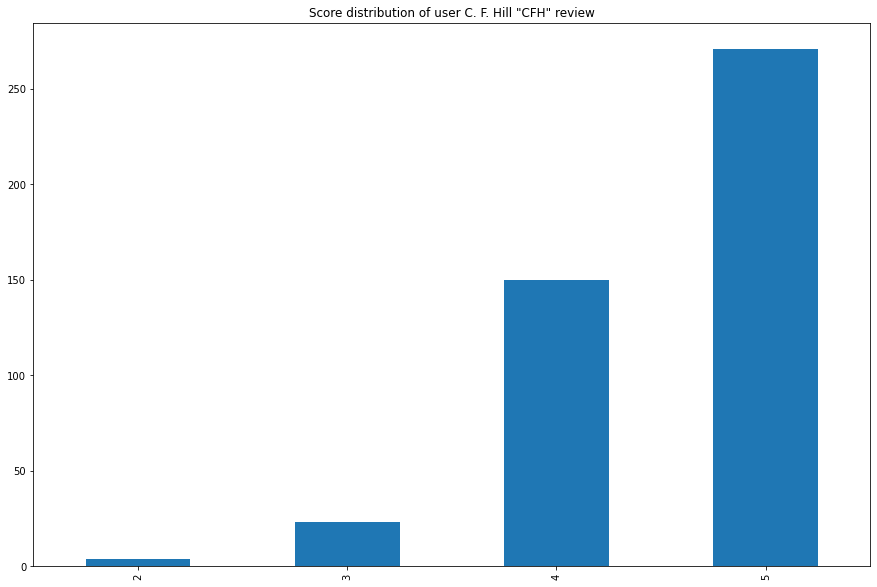

In [22]:
#The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

In [23]:
#It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


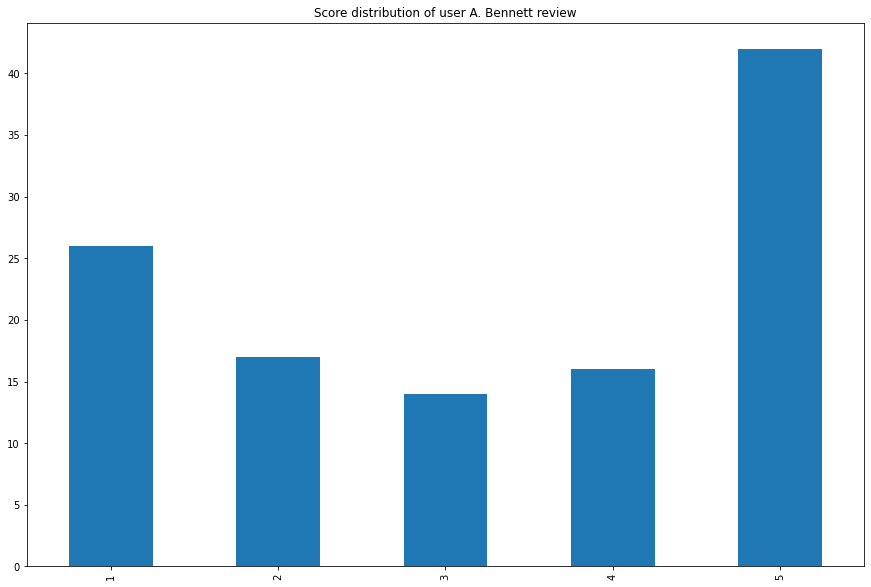

In [24]:
plot_user('A2M9D9BDHONV3Y')

In [25]:
#He seems like a better analysis target! Now let's dig deep into his reviews
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
   Count Occur %                   Phrase
0   11.0  42.31%             (never, buy)
1    9.0  34.62%           (buy, product)
2    8.0  30.77%    (never, buy, product)
3    8.0  30.77%  (monosodium, glutamate)
4    7.0  26.92%         (dry, tasteless)
5    7.0  26.92%          (picture, look)
6    7.0  26.92%            (decide, try)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%         (sauce, ruin)
1     8.0  47.06%  (sauce, ruin, whole)
2     8.0  47.06%         (ruin, whole)
3     7.0  41.18%           (give, try)
4     6.0  35.29%            (n't, buy)
5     6.0  35.29%       (product, ever)
6     5.0  29.41%     (give, try, like)
7     5.0  29.41%          (...., give)
8     5.0  29.41%           (try, like)
9     5.0  29.41%         (taste, like)
10    5.0  29.41%     (n't, get, wrong)
11    5.0  29.41%          (get, wrong)
12    5.0  29.41%            (n't, get)
13    5.0  2

In [26]:
#Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.

#Let's look at full picture now instead of just one user:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5547.0  10.61%   (taste, like)
1  2330.0   4.46%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1645.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   912.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3240.0    7.6%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1557.0   3.65%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1301.0   

In [27]:
#Maybe we should focus on popular single adjective word people used for different score. First we modify the function a bit for easier implementation:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [28]:
#Let's look at user A. Bennett again:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%     little
3   10.0  38.46%        bad
4    8.0  30.77%       hard
5    8.0  30.77%  expensive
6    8.0  30.77%  delicious
7    8.0  30.77%      tasty
8    7.0  26.92%      bread
9    7.0  26.92%       poor
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%       awful
3    6.0  35.29%       wrong
4    6.0  35.29%   delicious
5    5.0  29.41%  particular
6    5.0  29.41%        good
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%         first
3    4.0  28.57%         great
4    4.0  28.57%          good
5    4.0  28.57%  disappointed
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0    9.0  56.25%      great
1  

In [29]:
#Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
#Let's also look at big picture:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16224.0  31.04%          good
1   10804.0  20.67%           bad
2    4984.0   9.54%         great
3    4840.0   9.26%          much
4    4787.0   9.16%        little
5    4781.0   9.15%           old
6    4201.0   8.04%         first
7    3963.0   7.58%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3540.0   6.77%         small
11   3297.0   6.31%          real
12   2999.0   5.74%  disappointed
13   2889.0   5.53%          sure
14   2835.0   5.42%          free
15   2832.0   5.42%          diet
16   2769.0    5.3%          high
17   2659.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13548.0  45.51%          good
1    4252.0  14.28%          much
2    4198.0   14.1%           bad
3    3918.0  13.16%         great
4    3691.0   12.4%        little
5    2848.0   9.57%         small
6    2318.0   7.79%     